# MobileNetV2 YOLOv3 for Text Detection

A text detection model based on MobileNetV2 and YoloV3.<br>
Pruned and quantized for deployment on edge devices.

- [x] Pretrained MobileNetV2 backbone
- [x] YOLOv3 top end
- [x] Basic Pruning, Quantization integration
- [x] Training pipeline (for ICDAR 2015)

- [ ] Basic Inference
- [ ] Performance Evaluation
- [ ] Deflate Jupyter Notebook into file structure
- [ ] Advanced training pipeline (COCO-Text dataset, batch augmentation, mixed precision, etc.)
- [ ] Advanced Pruning and quantization
- [ ] Live-Feed Processing

In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.utils.prune as prune
import torch.quantization.quantize_fx as quantize_fx

from PIL import Image, ImageDraw
from pathlib import Path
from torch.nn import functional as F
from torchvision import transforms
from torch.quantization import quantize_dynamic
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [2]:
torch.manual_seed(42);
torch.cuda.manual_seed_all(42);

---

## Model Definition

In [3]:
class MobileYOLOv3(nn.Module):
    def __init__(self, num_classes):
        super(MobileYOLOv3, self).__init__()
        self.num_classes = num_classes
        self.mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        self.conv1 = nn.Conv2d(1280, 512, kernel_size=1)
        self.conv2 = nn.Conv2d(512, 5 * (num_classes + 5), kernel_size=1)

    def forward(self, x):
        x = self.mobilenet(x)
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return x.permute(0, 2, 3, 1).contiguous().view(x.size(0), 5, 8, 14, -1)  # Changed to (batch_size, 5, 8, 14, num_classes + 5)

---

## Loss Definition

In [4]:
class YoLoss(nn.Module):
    def __init__(self, num_classes):
        super(YoLoss, self).__init__()
        self.num_classes = num_classes
        self.mse_loss = nn.MSELoss(reduction='sum')
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='sum')

    def forward(self, predictions, targets):
        obj_pred = predictions[..., 4:5]
        class_pred = predictions[..., 5:]
        bbox_pred = predictions[..., :4]

        obj_target = targets[..., 4:5]
        class_target = targets[..., 5:]
        bbox_target = targets[..., :4]

        obj_loss = self.bce_loss(obj_pred, obj_target)
        class_loss = self.bce_loss(class_pred, class_target)
        bbox_loss = self.mse_loss(bbox_pred, bbox_target)

        total_loss = obj_loss + class_loss + bbox_loss
        return total_loss / predictions.size(0)

---

## Training

In [5]:
class ICDAR2015(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transforms.Compose([
            transforms.Resize((256, 448)),  # Changed to 16:9 aspect ratio
            transforms.ToTensor()
        ])
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        txt_name = 'gt_' + os.path.splitext(img_name)[0] + '.txt'
        txt_path = os.path.join(self.label_dir, txt_name)
        
        boxes = []
        try:
            with open(txt_path, 'r', encoding='utf-8-sig') as f:
                lines = f.read().strip().split('\n')
            
            for line in lines:
                parts = line.split(',')
                if len(parts) < 8:
                    continue
                try:
                    x1, y1, x2, y2, x3, y3, x4, y4 = map(float, parts[:8])
                    x_min, y_min = min(x1, x2, x3, x4), min(y1, y2, y3, y4)
                    x_max, y_max = max(x1, x2, x3, x4), max(y1, y2, y3, y4)
                    boxes.append([x_min, y_min, x_max, y_max])
                except ValueError:
                    print(f"Skipping invalid box in {txt_name}: {parts[:8]}")
        except Exception as e:
            print(f"Error reading {txt_name}: {str(e)}")
            boxes = [[0, 0, 1, 1]]
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        
        # Normalize box coordinates
        boxes[:, [0, 2]] /= image.shape[2]  # width
        boxes[:, [1, 3]] /= image.shape[1]  # height
        
        # Create target tensor (assuming 1 class for simplicity)
        target = torch.zeros((5, 8, 14, 6), dtype=torch.float32)  # Changed to 8x14 grid
        for box in boxes:
            i, j = min(int(box[1] * 8), 7), min(int(box[0] * 14), 13)  # Grid cell
            target[0, i, j, :4] = box
            target[0, i, j, 4] = 1  # objectness
            target[0, i, j, 5] = 1  # class (assuming 1 class only)
        
        return image, target

---

## Pruning & Quantization Definition

In [6]:
def prune_model(model, amount=0.7):
    for _, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)
            prune.remove(module, 'weight')
            if module.bias is not None:
                prune.l1_unstructured(module, name='bias', amount=amount/2)
                prune.remove(module, 'bias')
    parameters_to_prune = [(module, 'weight') for module in model.modules() if isinstance(module, (nn.Conv2d, nn.Linear))]
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount/2)
    return model

def quantize_model(model, device):
    model = model.cpu()  # Ensure the model is on the CPU as quantization happens on CPU
    quantized_model = torch.quantization.quantize_dynamic(
        model, {nn.Conv2d, nn.Linear}, dtype=torch.qint8, inplace=True  # Use inplace=True against deepcopy
    )
    return quantized_model.to(device)

---

## Training

In [7]:
batch_size = 32
num_workers = 4
num_classes = 1
learning_rate = 1e-3
num_epochs = 120
target_architecture = 'cuda' # else 'cpu'

# https://www.kaggle.com/datasets/bestofbests9/icdar2015
dataset_path = Path('/kaggle/input/icdar2015')
train_path = dataset_path / 'ch4_training_images'
train_labels = dataset_path / 'ch4_training_localization_transcription_gt'
test_path = dataset_path / 'ch4_test_images'
test_labels = dataset_path / 'ch4_test_localization_transcription_gt'

model_path = 'pq_yolov3_mobilenetv2.pth'

train_dataset = ICDAR2015(train_path, train_labels)
test_dataset = ICDAR2015(test_path, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using training device: {device}")

Using training device: cuda


In [8]:
model = MobileYOLOv3(num_classes=num_classes).to(device)
criterion = YoLoss(num_classes=num_classes)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

lossi = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):        
        data = data.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # if batch_idx % 10 == 0:
            # print(f"Batch {batch_idx}, Loss: {loss.item()}")
    
    lossi.append(epoch_loss/len(train_loader))
    print(f'Epoch [{epoch+1:3}/{num_epochs}], Loss: {lossi[-1]:.4f}')

Epoch [  1/150], Loss: 210.5480
Epoch [  2/150], Loss: 78.2173
Epoch [  3/150], Loss: 73.0015
Epoch [  4/150], Loss: 69.6350
Epoch [  5/150], Loss: 64.4332
Epoch [  6/150], Loss: 60.4539
Epoch [  7/150], Loss: 54.7693
Epoch [  8/150], Loss: 49.0236
Epoch [  9/150], Loss: 45.6551
Epoch [ 10/150], Loss: 42.4770
Epoch [ 11/150], Loss: 39.5187
Epoch [ 12/150], Loss: 35.4995
Epoch [ 13/150], Loss: 32.8436
Epoch [ 14/150], Loss: 29.5890
Epoch [ 15/150], Loss: 26.4183
Epoch [ 16/150], Loss: 24.4059
Epoch [ 17/150], Loss: 23.4072
Epoch [ 18/150], Loss: 22.8799
Epoch [ 19/150], Loss: 19.2899
Epoch [ 20/150], Loss: 18.2454
Epoch [ 21/150], Loss: 16.7334
Epoch [ 22/150], Loss: 15.7121
Epoch [ 23/150], Loss: 14.0758
Epoch [ 24/150], Loss: 12.3464
Epoch [ 25/150], Loss: 12.1950
Epoch [ 26/150], Loss: 11.9627
Epoch [ 27/150], Loss: 11.4354
Epoch [ 28/150], Loss: 9.3444
Epoch [ 29/150], Loss: 8.6085
Epoch [ 30/150], Loss: 7.6569
Epoch [ 31/150], Loss: 7.5382
Epoch [ 32/150], Loss: 5.5901
Epoch [ 33/1

In [9]:
# Prune, Quantize
quantized_model = quantize_model(prune_model(model), device)

# Save the quantized model
torch.save(quantized_model.state_dict(), model_path)

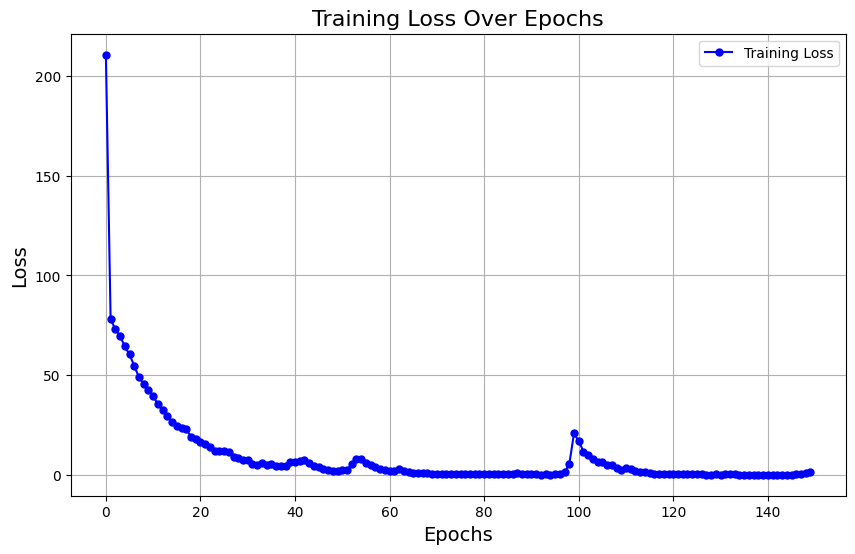

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), lossi, label="Training Loss", color='blue', marker='o', linestyle='-', markersize=5)

plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right')

plt.show();

In [11]:
def process_yolo_output(output, conf_threshold=0.5):
    batch_size, num_anchors, grid_h, grid_w, _ = output.shape
    output = output.view(batch_size, num_anchors * grid_h * grid_w, -1)
    
    output[..., 4:] = torch.sigmoid(output[..., 4:])
    mask = output[..., 4] > conf_threshold
    filtered_output = output[mask]
    
    if filtered_output.size(0) == 0:
        return torch.zeros((0, 4))

    boxes = filtered_output[:, :4]
    boxes[:, 0] = (boxes[:, 0] % grid_w + torch.div(boxes[:, 0], grid_w, rounding_mode='floor')) / grid_w
    boxes[:, 1] = (boxes[:, 1] % grid_h + torch.div(boxes[:, 1], grid_h, rounding_mode='floor')) / grid_h
    boxes[:, 2:] = torch.sigmoid(boxes[:, 2:])
    boxes[:, 2:] += boxes[:, :2]
    
    return boxes

def draw_boxes(img, boxes, color):
    """Draws boxes on the given image."""
    draw = ImageDraw.Draw(img)
    for box in boxes:
        if len(box) == 4:  # Ensure we have exactly 4 coordinates
            x1, y1, x2, y2 = box.tolist()
            draw.rectangle([x1, y1, x2, y2], outline=color, width=2)  # Draw rectangle
    return img

def visualize_inference(model, dataset, device, num_samples=3, conf_threshold=0.5, output_dir='inference_results'):
    model.eval()
    sampler = torch.utils.data.RandomSampler(dataset, num_samples=num_samples)
    loader = DataLoader(dataset, batch_size=1, sampler=sampler)
    os.makedirs(output_dir, exist_ok=True)

    for i, (data, targets) in enumerate(loader):
        data, targets = data.to(device), targets.to(device)
        
        with torch.no_grad():
            output = model(data)
        
        img = transforms.ToPILImage()(data.squeeze(0).cpu())
        w, h = img.size

        target_boxes = targets.reshape(-1, 6)[:, :4].cpu()
        target_boxes = target_boxes[target_boxes.sum(dim=1) > 0]
        target_boxes[:, [0, 2]] *= w
        target_boxes[:, [1, 3]] *= h
        img_with_targets = draw_boxes(img.copy(), target_boxes, "green")

        pred_boxes = process_yolo_output(output, conf_threshold).cpu()
        pred_boxes[:, [0, 2]] *= w
        pred_boxes[:, [1, 3]] *= h
        img_with_preds = draw_boxes(img.copy(), pred_boxes, "red")

        combined_img = Image.new('RGB', (w * 2, h))
        combined_img.paste(img_with_targets, (0, 0))
        combined_img.paste(img_with_preds, (w, 0))
        combined_img.save(os.path.join(output_dir, f'inference_result_{i+1}.png'))
        
        if i + 1 >= num_samples:
            break

    print(f"Inference results saved in directory: {output_dir}")

In [13]:
def load_model(model_class, model_path, target_device='cpu'):
    """
    Load a PyTorch model for inference on the target device, regardless of where it was originally trained.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No file at {model_path}")

    if isinstance(target_device, str):
        target_device = torch.device(target_device)

    # Load the state dict to CPU first
    state_dict = torch.load(model_path, map_location='cpu')
    
    # If it's a full checkpoint, extract just the model state dict
    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']

    # Remove pruning-related keys
    new_state_dict = {}
    for key, value in state_dict.items():
        if 'weight_mask' not in key:
            new_key = key.replace('weight_orig', 'weight')
            new_state_dict[new_key] = value
        
    model = model_class()
    model.load_state_dict(new_state_dict)
    model = model.to(target_device)
    model.eval()
    return model

In [12]:
model = load_model(MobileYOLOv3, num_classes, model_path, device)
dataset = ICDAR2015(train_path, train_labels)


# TODO: Runs, but doesn't work at all
visualize_inference(model, dataset, device)

/tmp/ipykernel_9651/2351444435.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


Inference results saved in directory: inference_results
